In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tensorflow

#### **Importer les bibliotheques**

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input

##**charger les datasets**

In [ ]:
indian_pines_path = "/content/drive/MyDrive/Hyperspectral_Data/Indian_pines.mat"
indian_pines_gt_path = "/content/drive/MyDrive/Hyperspectral_Data/Indian_pines_gt.mat"
pavia_university_path = "/content/drive/MyDrive/Hyperspectral_Data/PaviaU.mat"
pavia_university_gt_path = "/content/drive/MyDrive/Hyperspectral_Data/PaviaU_gt.mat"

# Charger Indian Pines
indian_pines_data = sio.loadmat(indian_pines_path)['indian_pines']
indian_pines_gt = sio.loadmat(indian_pines_gt_path)['indian_pines_gt']

# Charger Pavia University
PaviaU_data = sio.loadmat(pavia_university_path)['paviaU']
PaviaU_gt = sio.loadmat(pavia_university_gt_path)['paviaU_gt']


#**Indian Pines**

In [ ]:
def normalize_data(raw_data):
    max_value = np.max(raw_data)
    min_value = np.min(raw_data)
    normalized_data = (raw_data - min_value) / (max_value - min_value)
    return normalized_data

def dimension_PCA(data, input_dimension):
    lines, columns, num_bands = data.shape
    flattened_data = data.reshape(lines * columns, num_bands)

    # Apply PCA to the flattened data
    pca = PCA(n_components=input_dimension)
    pca.fit(flattened_data)

    # Transform the data back to the original shape
    transformed_data = pca.transform(flattened_data)
    whole_pca = transformed_data.reshape(lines, columns, input_dimension)

    return whole_pca

indian_pines_normalized = normalize_data(indian_pines_data)
indian_pines_pca = dimension_PCA(indian_pines_normalized, 10)
print(indian_pines_pca.shape)


(145, 145, 10)


#**SVM**

Shape après application du masque pour training : X_train = (10249, 10), y_train = (10249,)


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        37
           2       0.50      0.38      0.43      1143
           3       0.75      0.11      0.20       664
           4       0.92      0.06      0.11       190
           5       0.74      0.22      0.34       386
           6       0.71      0.97      0.82       584
           7       0.00      0.00      0.00        22
           8       0.84      0.99      0.91       382
           9       0.00      0.00      0.00        16
          10       0.53      0.30      0.39       778
          11       0.46      0.88      0.60      1964
          12       0.41      0.03      0.06       475
          13       0.81      0.90      0.85       164
          14       0.73      0.99      0.84      1012
          15       0.75      0.01      0.02       309
          16       1.00      0.82      0.90        74

    accuracy                           0.58      8200
  

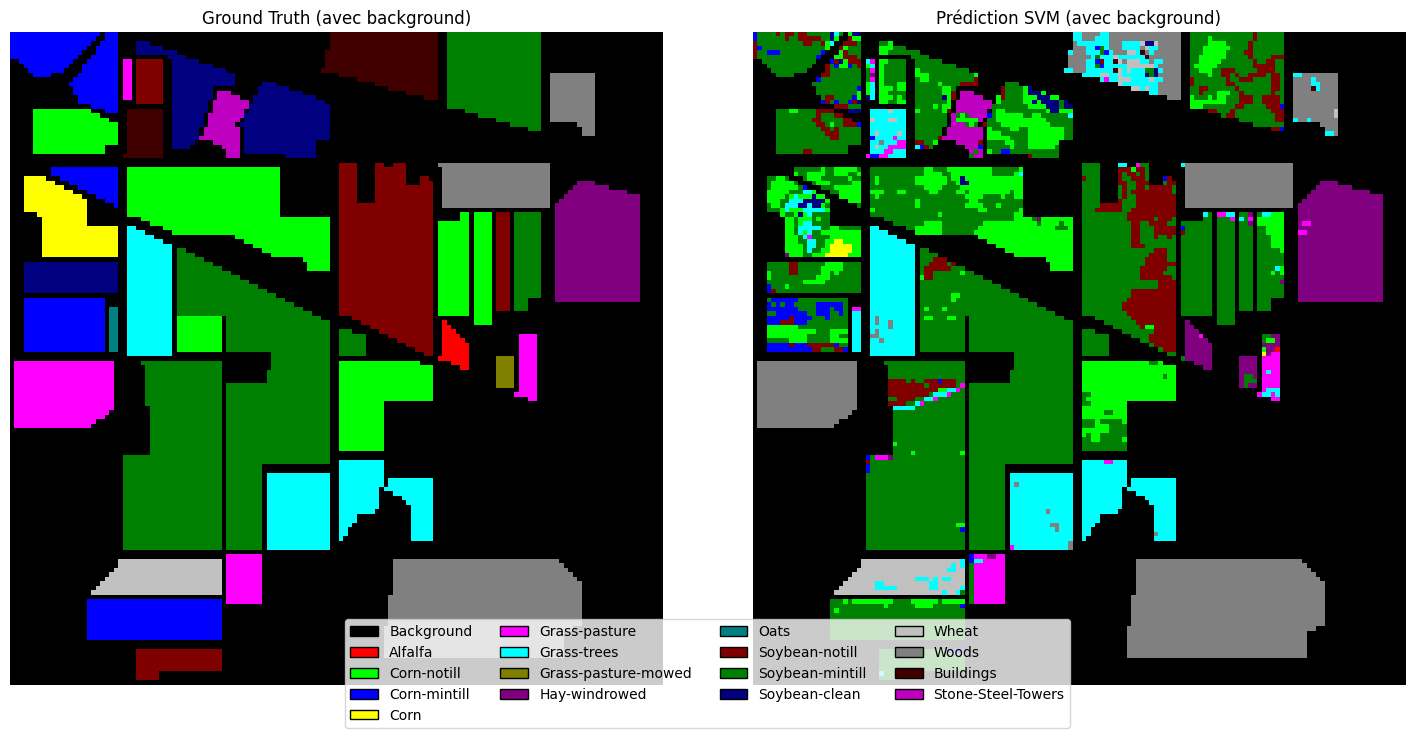

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.patches import Patch

# -----------------------------------------------
# 1. Préparation des données
lines, columns, num_bands = indian_pines_pca.shape
X = indian_pines_pca.reshape(lines * columns, num_bands)
y = indian_pines_gt.reshape(-1)

# Masquer uniquement pour l'entraînement (pas pour affichage final)
mask = y > 0
X_train = X[mask]
y_train = y[mask]

print(f"Shape après application du masque pour training : X_train = {X_train.shape}, y_train = {y_train.shape}")

# -----------------------------------------------
# 2. Séparer en train/test
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.8, random_state=42, shuffle=True, stratify=y_train
)

# -----------------------------------------------
# 3. Entraîner SVM
svm = SVC(kernel='rbf', gamma='scale', random_state=42)
svm.fit(X_train_split, y_train_split)

# Prédictions sur le test
y_pred_split = svm.predict(X_test_split)

# Evaluation
print("Classification Report:\n", classification_report(y_test_split, y_pred_split))
print("Confusion Matrix:\n", confusion_matrix(y_test_split, y_pred_split))

# -----------------------------------------------
# 4. Prédiction sur toute l'image
y_pred_full = np.zeros_like(y)
y_pred_full[mask] = svm.predict(X_train)

# -----------------------------------------------
# 5. Palette fixe (background 0 ajouté en noir)
palette_india = {
    0: (0, 0, 0),       # Background - noir
    1: (255, 0, 0),     # Alfalfa - rouge
    2: (0, 255, 0),     # Corn-notill - vert
    3: (0, 0, 255),     # Corn-mintill - bleu
    4: (255, 255, 0),   # Corn - jaune
    5: (255, 0, 255),   # Grass-pasture - magenta
    6: (0, 255, 255),   # Grass-trees - cyan
    7: (128, 128, 0),   # Grass-pasture-mowed - olive
    8: (128, 0, 128),   # Hay-windrowed - violet
    9: (0, 128, 128),   # Oats - turquoise
    10: (128, 0, 0),    # Soybean-notill - marron
    11: (0, 128, 0),    # Soybean-mintill - vert foncé
    12: (0, 0, 128),    # Soybean-clean - bleu foncé
    13: (192, 192, 192),# Wheat - gris clair
    14: (128, 128, 128),# Woods - gris
    15: (64, 0, 0),     # Buildings - brun foncé
    16: (192, 0, 192)   # Stone-Steel-Towers - violet clair
}

india_names_class = {
    0: "Background",
    1: "Alfalfa",
    2: "Corn-notill",
    3: "Corn-mintill",
    4: "Corn",
    5: "Grass-pasture",
    6: "Grass-trees",
    7: "Grass-pasture-mowed",
    8: "Hay-windrowed",
    9: "Oats",
    10: "Soybean-notill",
    11: "Soybean-mintill",
    12: "Soybean-clean",
    13: "Wheat",
    14: "Woods",
    15: "Buildings",
    16: "Stone-Steel-Towers"
}

# Fonction pour mapper l'image selon la palette
def apply_palette(label_map, palette):
    rgb_image = np.zeros((label_map.shape[0], label_map.shape[1], 3), dtype=np.uint8)
    for label, color in palette.items():
        mask = label_map == label
        rgb_image[mask] = color
    return rgb_image

# Appliquer la palette
prediction_map = y_pred_full.reshape(lines, columns)
ground_truth_map = y.reshape(lines, columns)

prediction_rgb = apply_palette(prediction_map, palette_india)
ground_truth_rgb = apply_palette(ground_truth_map, palette_india)

# -----------------------------------------------
# 6. Affichage avec background en noir

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(ground_truth_rgb)
axs[0].set_title('Ground Truth (avec background)')
axs[0].axis('off')

axs[1].imshow(prediction_rgb)
axs[1].set_title('Prédiction SVM (avec background)')
axs[1].axis('off')

# Légende avec background aussi
legend_elements = [Patch(facecolor=np.array(color)/255, edgecolor='k', label=india_names_class[label]) for label, color in palette_india.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

oa = accuracy_score(y_test_split, y_pred_split)
kappa = cohen_kappa_score(y_test_split, y_pred_split)

print(f"Overall Accuracy (OA) = {oa:.4f}")
print(f"Kappa Coefficient = {kappa:.4f}")


Overall Accuracy (OA) = 0.5784
Kappa Coefficient = 0.4970


#**1D CNN**

In [ ]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score,cohen_kappa_score


# -----------------------------------------------
# 1. Données
lines, columns, num_bands = indian_pines_pca.shape
X = indian_pines_pca.reshape(lines * columns, num_bands)
y = indian_pines_gt.reshape(-1)

mask = y > 0
X = X[mask]
y = y[mask]

# Reshape pour CNN : (n_samples, longueur_sequence, 1)
X = X.reshape(-1, num_bands, 1)

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42, stratify=y
)
print(f"X_test shape: {X_test.shape}, y_train shape: {y_test.shape}")

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# -----------------------------------------------
# 2. Modèle 1D CNN

model = Sequential([
    Conv1D(32, kernel_size=5, padding='same', input_shape=(num_bands, 1)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    Conv1D(64, kernel_size=5, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(np.max(y)+1, activation='softmax')  # Attention: nombre de classes = max(y) + 1
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# -----------------------------------------------
# 3. Entraînement

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# -----------------------------------------------
# 4. Évaluation

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_labels))

oa = accuracy_score(y_test, y_pred_labels)
kappa = cohen_kappa_score(y_test, y_pred_labels)
print(f"Overall Accuracy (OA): {oa:.4f}")
print(f"Kappa Coefficient: {kappa:.4f}")


X_test shape: (7175, 10, 1), y_train shape: (7175,)
X_train shape: (3074, 10, 1), y_train shape: (3074,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 10, 32)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 10, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 10, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,393 (83.57 KB)

 Trainable params: 21,201 (82.82 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.2816 - loss: 2.3240 - val_accuracy: 0.2396 - val_loss: 2.5024
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4397 - loss: 1.6734 - val_accuracy: 0.2998 - val_loss: 2.4088
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4654 - loss: 1.5284 - val_accuracy: 0.2240 - val_loss: 2.3055
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4671 - loss: 1.4566 - val_accuracy: 0.3880 - val_loss: 2.0086
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4864 - loss: 1.3844 - val_accuracy: 0.4223 - val_loss: 1.6578
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4955 - loss: 1.3804 - val_accuracy: 0.4992 - val_loss: 1.3700
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5237 - loss: 1.2957 - val_accuracy: 0.5320 - val_loss: 1.2522
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5364 - loss: 1.2601 - val_accuracy: 0.55

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


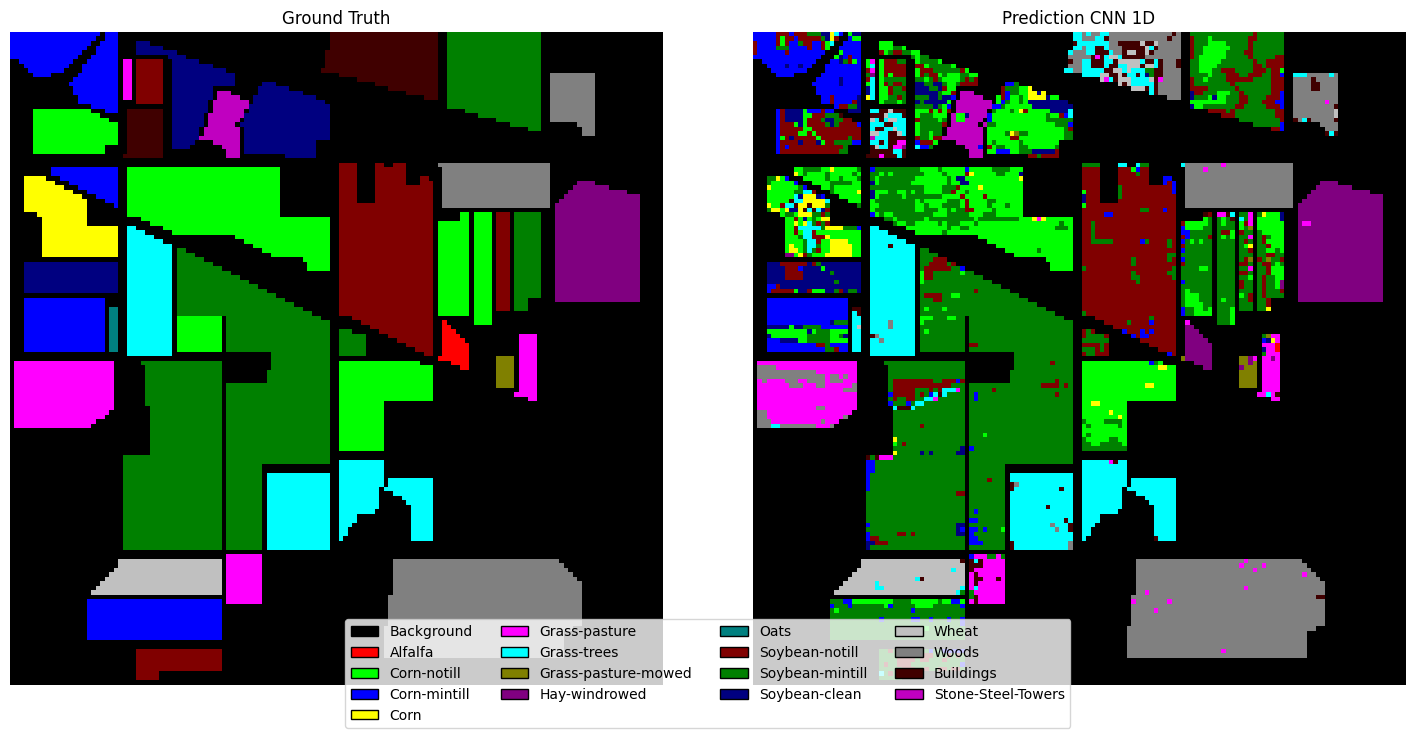

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# -----------------------------------------------
# Predict only non-background pixels

# Find valid (non-background) pixel positions
valid_positions = np.where(indian_pines_gt.ravel() != 0)[0]

# Prepare only valid samples
X_valid = indian_pines_pca.reshape(-1, num_bands)[valid_positions]
X_valid_cnn = X_valid.reshape(-1, num_bands, 1)

# Predict only on valid pixels
y_pred_valid = np.argmax(model.predict(X_valid_cnn, batch_size=512, verbose=1), axis=1)

# -----------------------------------------------
# Build a full prediction map (black by default)

prediction_map = np.zeros((lines * columns), dtype=np.uint8)  # 0 = black
prediction_map[valid_positions] = y_pred_valid

prediction_map = prediction_map.reshape(lines, columns)

# -----------------------------------------------
# Color palette (same as before)

palette_india = {
    0: (0, 0, 0),       # Background - Black
    1: (255, 0, 0),     # Alfalfa - Red
    2: (0, 255, 0),     # Corn-notill - Green
    3: (0, 0, 255),     # Corn-mintill - Blue
    4: (255, 255, 0),   # Corn - Yellow
    5: (255, 0, 255),   # Grass-pasture - Magenta
    6: (0, 255, 255),   # Grass-trees - Cyan
    7: (128, 128, 0),   # Grass-pasture-mowed - Olive
    8: (128, 0, 128),   # Hay-windrowed - Violet
    9: (0, 128, 128),   # Oats - Turquoise
    10: (128, 0, 0),    # Soybean-notill - Maroon
    11: (0, 128, 0),    # Soybean-mintill - Dark Green
    12: (0, 0, 128),    # Soybean-clean - Dark Blue
    13: (192, 192, 192),# Wheat - Light Gray
    14: (128, 128, 128),# Woods - Gray
    15: (64, 0, 0),     # Buildings - Dark Brown
    16: (192, 0, 192)   # Stone-Steel-Towers - Light Violet
}

india_names_class = {
    0: "Background",
    1: "Alfalfa",
    2: "Corn-notill",
    3: "Corn-mintill",
    4: "Corn",
    5: "Grass-pasture",
    6: "Grass-trees",
    7: "Grass-pasture-mowed",
    8: "Hay-windrowed",
    9: "Oats",
    10: "Soybean-notill",
    11: "Soybean-mintill",
    12: "Soybean-clean",
    13: "Wheat",
    14: "Woods",
    15: "Buildings",
    16: "Stone-Steel-Towers"
}

# -----------------------------------------------
# Apply palette function

def apply_palette(label_map, palette):
    rgb_image = np.zeros((label_map.shape[0], label_map.shape[1], 3), dtype=np.uint8)
    for label, color in palette.items():
        rgb_image[label_map == label] = color
    return rgb_image

# Prepare RGB images
ground_truth_rgb = apply_palette(indian_pines_gt, palette_india)
prediction_rgb = apply_palette(prediction_map, palette_india)

# -----------------------------------------------
# Display results

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(ground_truth_rgb)
axs[0].set_title('Ground Truth')
axs[0].axis('off')

axs[1].imshow(prediction_rgb)
axs[1].set_title('Prediction CNN 1D')
axs[1].axis('off')

# Legend
legend_elements = [
    Patch(facecolor=np.array(color)/255, edgecolor='k', label=india_names_class[label])
    for label, color in palette_india.items()
]

fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()


##**Pavia University**

In [ ]:
def normalize_data(raw_data):
    max_value = np.max(raw_data)
    min_value = np.min(raw_data)
    normalized_data = (raw_data - min_value) / (max_value - min_value)
    return normalized_data

def dimension_PCA(data, input_dimension):
    lines, columns, num_bands = data.shape
    flattened_data = data.reshape(lines * columns, num_bands)

    # Apply PCA to the flattened data
    pca = PCA(n_components=input_dimension)
    pca.fit(flattened_data)

    # Transform the data back to the original shape
    transformed_data = pca.transform(flattened_data)
    whole_pca = transformed_data.reshape(lines, columns, input_dimension)

    return whole_pca

pavia_normalized = normalize_data(PaviaU_data)
pavia_pca = dimension_PCA(pavia_normalized, 3)
print(pavia_pca.shape)


(610, 340, 3)


#**SVM**

In [ ]:
# -----------------------------------------------
# 2. Préparation des données
lines, columns, num_bands = pavia_pca.shape
X = pavia_pca.reshape(lines * columns, num_bands)
y = PaviaU_gt.reshape(-1)

# Masquer uniquement pour l'entraînement (pas pour affichage final)
mask = y > 0
X_train = X[mask]
y_train = y[mask]

print(f"Shape après application du masque pour training : X_train = {X_train.shape}, y_train = {y_train.shape}")

# -----------------------------------------------
# 3. Séparer en train/test
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, shuffle=True, stratify=y_train
)

# -----------------------------------------------
# 4. Entraîner SVM
svm = SVC(kernel='rbf', gamma='scale',random_state=42)
svm.fit(X_train_split, y_train_split)

# Prédictions sur le test
y_pred_split = svm.predict(X_test_split)

# Evaluation
print("Classification Report:\n", classification_report(y_test_split, y_pred_split))
print("Confusion Matrix:\n", confusion_matrix(y_test_split, y_pred_split))

Shape après application du masque pour training : X_train = (42776, 3), y_train = (42776,)
Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.93      0.84      1989
           2       0.79      0.99      0.88      5595
           3       0.53      0.15      0.23       630
           4       0.94      0.75      0.83       919
           5       1.00      0.99      0.99       403
           6       0.95      0.21      0.34      1509
           7       0.50      0.00      0.00       399
           8       0.67      0.91      0.77      1105
           9       1.00      1.00      1.00       284

    accuracy                           0.79     12833
   macro avg       0.79      0.66      0.66     12833
weighted avg       0.80      0.79      0.75     12833

Confusion Matrix:
 [[1848    8   27    0    1   12    0   93    0]
 [   0 5547    0   42    0    4    0    2    0]
 [ 139    5   94    0    0    0    1  391    0]
 [   0  234    0 

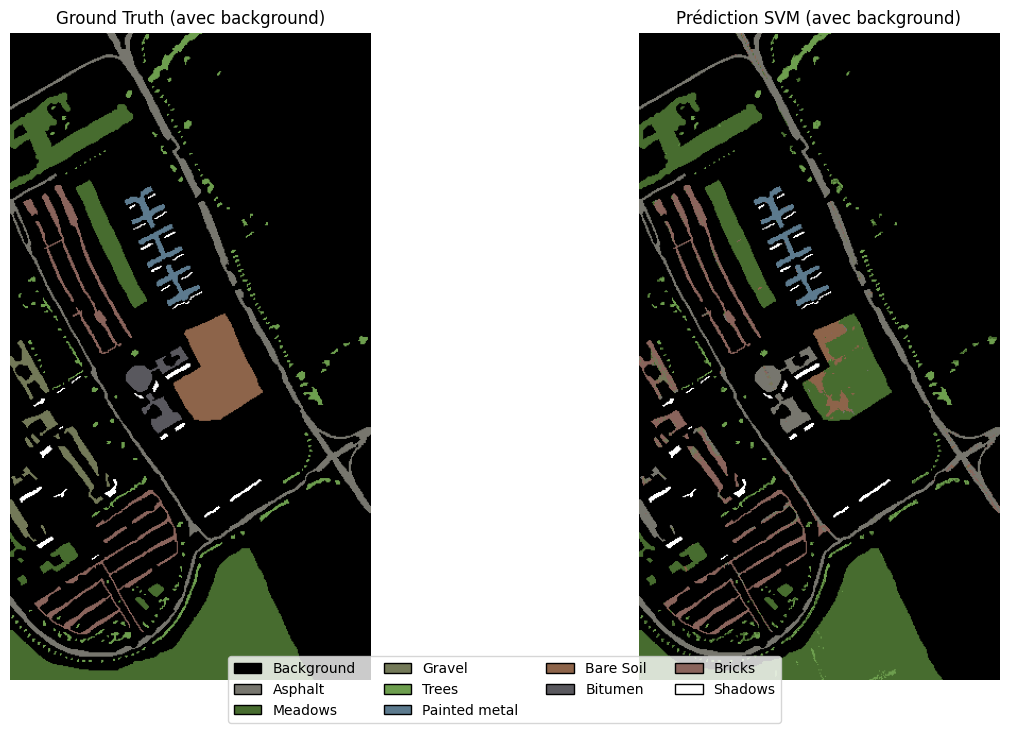

In [ ]:


# -----------------------------------------------
# 5. Prédiction sur toute l'image
y_pred_full = np.zeros_like(y)
y_pred_full[mask] = svm.predict(X_train)

# -----------------------------------------------
# 6. Palette fixe (background 0 ajouté en noir)
palette = {
    0: (0, 0, 0),       # Background - noir
    1: (119, 118, 110), # Asphalt
    2: (71, 108, 47),   # Meadows
    3: (115, 121, 88),  # Gravel
    4: (109, 158, 78),  # Trees
    5: (92, 122, 142),  # Painted metal
    6: (141, 100, 74),  # Bare Soil
    7: (89, 88, 94),    # Bitumen
    8: (138, 100, 92),  # Bricks
    9: (255, 255, 255)  # Shadows
}

class_names = {
    0: "Background",
    1: "Asphalt",
    2: "Meadows",
    3: "Gravel",
    4: "Trees",
    5: "Painted metal",
    6: "Bare Soil",
    7: "Bitumen",
    8: "Bricks",
    9: "Shadows"
}

# Fonction pour mapper l'image selon la palette
def apply_palette(label_map, palette):
    rgb_image = np.zeros((label_map.shape[0], label_map.shape[1], 3), dtype=np.uint8)
    for label, color in palette.items():
        mask = label_map == label
        rgb_image[mask] = color
    return rgb_image

# Appliquer la palette
prediction_map = y_pred_full.reshape(lines, columns)
ground_truth_map = y.reshape(lines, columns)

prediction_rgb = apply_palette(prediction_map, palette)
ground_truth_rgb = apply_palette(ground_truth_map, palette)

# -----------------------------------------------
# 7. Affichage avec background en noir

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(ground_truth_rgb)
axs[0].set_title('Ground Truth (avec background)')
axs[0].axis('off')

axs[1].imshow(prediction_rgb)
axs[1].set_title('Prédiction SVM (avec background)')
axs[1].axis('off')

# Légende avec background aussi
legend_elements = [Patch(facecolor=np.array(color)/255, edgecolor='k', label=class_names[label]) for label, color in palette.items()]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()


# **1D CNN**

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score

# -----------------------------------------------
# 1. Données
lines, columns, num_bands = pavia_pca.shape
X = pavia_pca.reshape(lines * columns, num_bands)
y = PaviaU_gt.reshape(-1)

# Masquer background (label 0) pour l'entraînement
mask = y > 0
X = X[mask]
y = y[mask]

# Reshape pour CNN : (n_samples, longueur_sequence, 1)
X = X.reshape(-1, num_bands, 1)

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# -----------------------------------------------
# 2. Modèle 1D CNN

model = Sequential([
    Conv1D(32, kernel_size=3, padding='same', input_shape=(num_bands, 1)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),

    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(np.max(y) + 1, activation='softmax')  # Nombre de classes = max label + 1
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# -----------------------------------------------
# 3. Entraînement

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# -----------------------------------------------
# 4. Évaluation

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print("Classification Report:\n", classification_report(y_test, y_pred_labels))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_labels))

oa = accuracy_score(y_test, y_pred_labels)
kappa = cohen_kappa_score(y_test, y_pred_labels)
print(f"Overall Accuracy (OA): {oa:.4f}")
print(f"Kappa Coefficient: {kappa:.4f}")


X_train shape: (12832, 3, 1), y_train shape: (12832,)
X_test shape: (29944, 3, 1), y_test shape: (29944,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 3, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 3, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 3, 64)          │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 3, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,530 (45.04 KB)

 Trainable params: 11,338 (44.29 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5550 - loss: 1.3345 - val_accuracy: 0.7165 - val_loss: 0.7283
Epoch 2/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7091 - loss: 0.7200 - val_accuracy: 0.7673 - val_loss: 0.5623
Epoch 3/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7249 - loss: 0.6638 - val_accuracy: 0.7523 - val_loss: 0.5558
Epoch 4/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7388 - loss: 0.6384 - val_accuracy: 0.7632 - val_loss: 0.5400
Epoch 5/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7398 - loss: 0.6343 - val_accuracy: 0.7652 - val_loss: 0.5380
Epoch 6/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7481 - loss: 0.6014 - val_accuracy: 0.7699 - val_loss: 0.5335
Epoch 7/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7434 - loss: 0.6154 - val_accuracy: 0.7685 - val_loss: 0.5299
Epoch 8/100
401/401 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7472 - loss: 0.6043 - val_ac

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


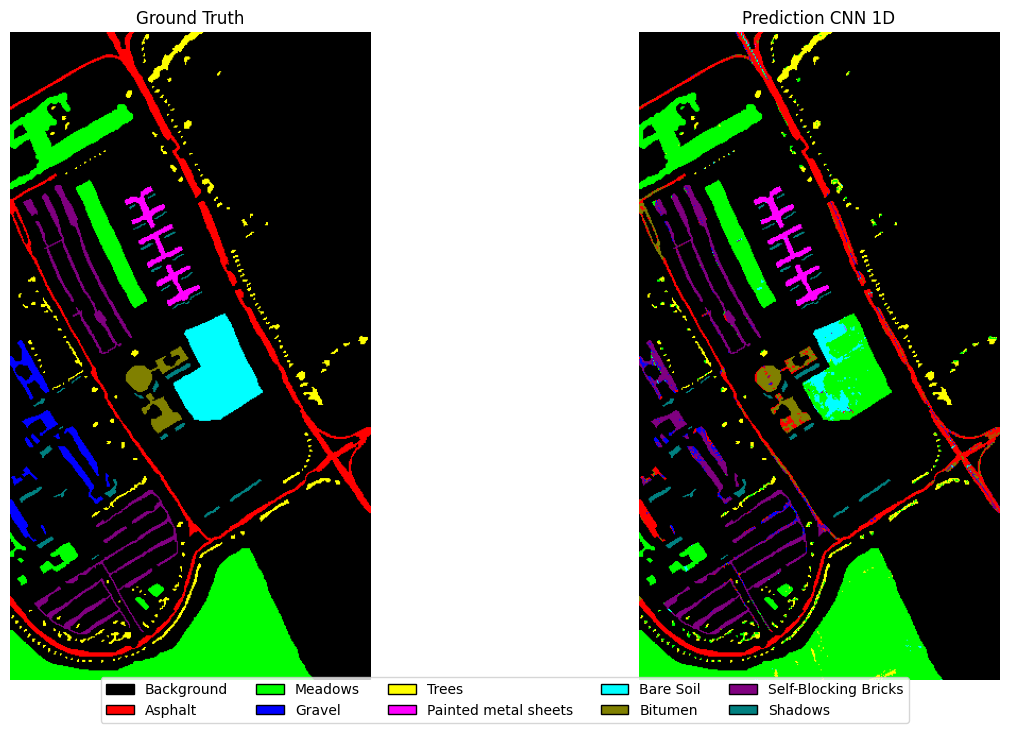

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# -----------------------------------------------
# Predict only non-background pixels

# Find valid (non-background) pixel positions
valid_positions = np.where(PaviaU_gt.ravel() != 0)[0]

# Prepare only valid samples
X_valid = pavia_pca.reshape(-1, num_bands)[valid_positions]
X_valid_cnn = X_valid.reshape(-1, num_bands, 1)

# Predict only on valid pixels
y_pred_valid = np.argmax(model.predict(X_valid_cnn, batch_size=512, verbose=1), axis=1)

# -----------------------------------------------
# Build a full prediction map (black by default)

prediction_map = np.zeros((lines * columns), dtype=np.uint8)  # 0 = black
prediction_map[valid_positions] = y_pred_valid

prediction_map = prediction_map.reshape(lines, columns)

# -----------------------------------------------
# Color palette for Pavia University

palette_paviaU = {
    0: (0, 0, 0),         # Background - Black
    1: (255, 0, 0),       # Asphalt - Red
    2: (0, 255, 0),       # Meadows - Green
    3: (0, 0, 255),       # Gravel - Blue
    4: (255, 255, 0),     # Trees - Yellow
    5: (255, 0, 255),     # Painted metal sheets - Magenta
    6: (0, 255, 255),     # Bare Soil - Cyan
    7: (128, 128, 0),     # Bitumen - Olive
    8: (128, 0, 128),     # Self-Blocking Bricks - Violet
    9: (0, 128, 128)      # Shadows - Turquoise
}

paviaU_names_class = {
    0: "Background",
    1: "Asphalt",
    2: "Meadows",
    3: "Gravel",
    4: "Trees",
    5: "Painted metal sheets",
    6: "Bare Soil",
    7: "Bitumen",
    8: "Self-Blocking Bricks",
    9: "Shadows"
}

# -----------------------------------------------
# Apply palette function

def apply_palette(label_map, palette):
    rgb_image = np.zeros((label_map.shape[0], label_map.shape[1], 3), dtype=np.uint8)
    for label, color in palette.items():
        rgb_image[label_map == label] = color
    return rgb_image

# Prepare RGB images
ground_truth_rgb = apply_palette(PaviaU_gt, palette_paviaU)
prediction_rgb = apply_palette(prediction_map, palette_paviaU)

# -----------------------------------------------
# Display results

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].imshow(ground_truth_rgb)
axs[0].set_title('Ground Truth')
axs[0].axis('off')

axs[1].imshow(prediction_rgb)
axs[1].set_title('Prediction CNN 1D')
axs[1].axis('off')

# Legend
legend_elements = [
    Patch(facecolor=np.array(color)/255, edgecolor='k', label=paviaU_names_class[label])
    for label, color in palette_paviaU.items()
]

fig.legend(handles=legend_elements, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.show()


why Bare Soil might often be confused with Meadows:

> Add blockquote




1.   Spectral similarity (especially after PCA)

* Bare soils and low-grass meadows can reflect similarly in some wavelengths, especially in near-infrared and visible ranges after PCA compression.

2.   Spatial resolution issue (mixed pixels)

* Pavia University data has relatively coarse resolution (~1.3 meters per pixel).
* A pixel labeled as "bare soil" might contain both dirt and some grass or plants.
* Thus, its spectral content is a mixture — not pure — and might "look like" meadow spectrally.